# Baseline CNN

1. Best Model
2. Simple Model

In [ ]:
!pip install deap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 139 kB 35.5 MB/s 


In [ ]:
import os
import tarfile
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import random
from sympy.combinatorics.graycode import GrayCode
from sympy.combinatorics.graycode import gray_to_bin
from sympy.combinatorics.graycode import bin_to_gray
from deap import creator, base, tools, algorithms
import numpy as np

from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ExponentialLR


In [ ]:
#dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
#download_url(dataset_url, '.')
#with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    #tar.extractall(path='./data')
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
train_ds = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
test_ds = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size*2, shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("yh")
else:
    device = torch.device("cpu")
    print("nah :(")

yh


## Best Performing CNN Architecture 

BUT WITH MANY PARAMETERS -> 13 mins to run with CUDA

In [ ]:
def ConvLayer(inp, out, ks=3, s=1, p=1):
    return nn.Conv2d(inp, out, kernel_size=ks, stride=s, padding=p)
class CIFAR10(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = ConvLayer(3, 32)
        self.conv2 = ConvLayer(32, 64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv3 = ConvLayer(64, 128)
        self.conv4 = ConvLayer(128, 256)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv5 = ConvLayer(256, 512)
        self.conv6 = ConvLayer(512, 1024)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(1024*4*4, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool2(F.relu(self.conv4(x)))
        x = F.relu(self.conv5(x))
        x = self.pool3(F.relu(self.conv6(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
#model = CIFAR10()
model = CIFAR10().to(device)
print(model)
model.fc3.requires_grad_(False)

CIFAR10(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=10, bias=True)
)


Linear(in_features=512, out_features=10, bias=True)

In [ ]:
def accuracy_score(out, labels):
    _, preds = torch.max(out, dim=1)
    correct_preds = torch.sum(preds==labels).item()
    total_preds = len(preds)
    accuracy = torch.tensor(correct_preds/total_preds)
    return accuracy

## Model Performance

Maximum Testing Accuracy is:

In [ ]:
train_acc = []
test_acc =[]

In [ ]:
%%time
num_epochs = 9
learning_rate = 0.0003
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    total_training_accuracies = []
    total_testing_accuracies = []
    for img, labels in train_loader:
        img = img.to(device)
        labels = labels.to(device)
        pred = model(img)
        loss = loss_func(pred, labels)
        metrics = accuracy_score(pred, labels)
        total_training_accuracies.append(metrics)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print("Epoch Number: ", epoch+1, " | Training Accuracy Score: ", sum(total_training_accuracies)/len(total_training_accuracies))
    train_acc.append(sum(total_training_accuracies)/len(total_training_accuracies))
    for test_img, test_labels in test_loader:
        test_img = test_img.to(device)
        test_labels = test_labels.to(device)
        test_preds = model(test_img)
        metrics = accuracy_score(test_preds, test_labels)
        total_testing_accuracies.append(metrics)
    print("Epoch Number: ", epoch+1, " | Testing Accuracy Score: ", sum(total_testing_accuracies)/len(total_testing_accuracies))
    test_acc.append(sum(total_testing_accuracies)/len(total_testing_accuracies))
print('Finito')

Epoch Number:  1  | Training Accuracy Score:  tensor(0.3997)
Epoch Number:  1  | Testing Accuracy Score:  tensor(0.5154)
Epoch Number:  2  | Training Accuracy Score:  tensor(0.5811)
Epoch Number:  2  | Testing Accuracy Score:  tensor(0.6171)
Epoch Number:  3  | Training Accuracy Score:  tensor(0.6827)
Epoch Number:  3  | Testing Accuracy Score:  tensor(0.6893)
Epoch Number:  4  | Training Accuracy Score:  tensor(0.7478)
Epoch Number:  4  | Testing Accuracy Score:  tensor(0.7304)
Epoch Number:  5  | Training Accuracy Score:  tensor(0.7994)
Epoch Number:  5  | Testing Accuracy Score:  tensor(0.7625)
Epoch Number:  6  | Training Accuracy Score:  tensor(0.8449)
Epoch Number:  6  | Testing Accuracy Score:  tensor(0.7816)
Epoch Number:  7  | Training Accuracy Score:  tensor(0.8868)
Epoch Number:  7  | Testing Accuracy Score:  tensor(0.7827)
Epoch Number:  8  | Training Accuracy Score:  tensor(0.9237)
Epoch Number:  8  | Testing Accuracy Score:  tensor(0.7877)
Epoch Number:  9  | Training Acc

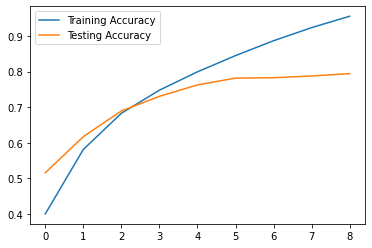

In [ ]:
import matplotlib.pyplot as plt
import numpy as np



epochs = np.arange(0,num_epochs,1)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, test_acc, label='Testing Accuracy')
plt.legend()

In [ ]:
PATH = './cifar_net.pth'
torch.save(model.state_dict(), PATH)

## Training the final layer with GA

In [ ]:
batch_size = 500
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
test_loader = DataLoader(test_ds, batch_size/2, shuffle=True)

ValueError: ignored

Imports Good
  Evaluated 100 individuals
Best individual is:
17.78258514404297
Testing Accuracy Score before training:  tensor(0.0802)
-- Generation 10 --
  Worst 38.727176666259766
  Best 10.621341705322266
  Avg 17.05786138011519
  Std 0.01112818245982212
Testing Accuracy Score:  tensor(0.1879)
-- Generation 20 --
  Worst 18.463298797607422
  Best 8.590991020202637
  Avg 12.558459437853081
  Std 0.01520806166876431
Testing Accuracy Score:  tensor(0.1957)
-- Generation 30 --
  Worst 21.511560440063477
  Best 7.837737083435059
  Avg 10.10731970891266
  Std 0.015521431871818337
Testing Accuracy Score:  tensor(0.1645)
-- Generation 40 --
  Worst 14.794680595397947
  Best 5.017780780792236
  Avg 7.802539065357545
  Std 0.023104374429162165
Testing Accuracy Score:  tensor(0.3138)
-- Generation 50 --
  Worst 9.860028266906738
  Best 3.6050245761871342
  Avg 4.998138053415163
  Std 0.04020133505410718
Testing Accuracy Score:  tensor(0.4096)
-- Generation 60 --
  Worst 6.526196002960205
  Bes

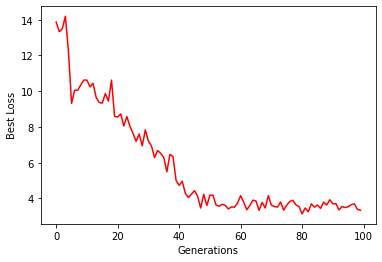

NameError: name 'test_acc' is not defined

In [ ]:
%%time
import random
from sympy.combinatorics.graycode import GrayCode
from sympy.combinatorics.graycode import gray_to_bin
from sympy.combinatorics.graycode import bin_to_gray
from deap import creator, base, tools, algorithms
import numpy as np
torch.cuda.empty_cache()
print('Imports Good')
PATH = './cifar_net.pth'

loss_func = nn.CrossEntropyLoss()
net = CIFAR10().to(device)
net.load_state_dict(torch.load(PATH))
torch.no_grad()
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

popSize     = 100 #Population size
dimension   = 5130 #Number of decision variable x 
numOfBits   = 10 #Number of bits in the decision variable
iterations  = 100 #Number of generations to be run
dspInterval = 10
nElitists   = 1 #number of elite individuals selected
omega       = 5
crossPoints = 2 #variable not used. instead tools.cxTwoPoint
crossProb   = 0.6
flipProb    = 1. / (dimension * numOfBits) #bit mutate prob
mutateprob  = .15 #mutation prob
maxnum      = 2**numOfBits #absolute max size of number coded by binary list 1,0,0,1,1,....

list_fits = [] 
test_acc3 =[]
toolbox = base.Toolbox()

# Attribute generator 
#                      define 'attr_bool' to be an attribute ('gene')
#                      which corresponds to integers sampled uniformly
#                      from the range [0,1] (i.e. 0 or 1 with equal
#                      probability)
toolbox.register("attr_bool", random.randint, 0, 1)

# Structure initializers
#                         define 'individual' to be an individual
#                         consisting of numOfBits*dimension 'attr_bool' elements ('genes')
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_bool, numOfBits*dimension)

# define the population to be a list of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    
#----------
# Operator registration
#----------
# register the goal / fitness function
#toolbox.register("evaluate", fitness)

# register the crossover operator
toolbox.register("mate", tools.cxTwoPoint)

# register a mutation operator with a probability to
# flip each attribute/gene of 0.05
toolbox.register("mutate", tools.mutFlipBit, indpb=flipProb)

# operator for selecting individuals for breeding the next
# generation: each individual of the current generation
# is replaced by the 'fittest' (best) of three individuals
# drawn randomly from the current generation.
toolbox.register("select", tools.selRoulette, fit_attr='fitness')

#----------

# Convert chromosome to real number
# input: list binary 1,0 of length numOfBits representing number using gray coding
# output: real value
def chrom2real(c):
    indasstring=''.join(map(str, c))
    degray=gray_to_bin(indasstring)
    numasint=int(degray, 2) # convert to int from base 2 list
    num = (numasint/512) - 1 
    return num

# input: concatenated list of binary variables
# output: tuple of real numbers representing those variables
def separatevariables(v):
    return chrom2real(v[0:numOfBits]),chrom2real(v[numOfBits:])

def weightify(pop):
    weights = []
    for n in range(len(pop)):
        for  i in range(dimension):
            i = pop[n][10*i:10*(i+1)]
            weights.append(chrom2real(i))
    weights = np.array(weights, dtype = 'float32')
    weights = np.reshape(weights, (len(pop), dimension))
    return(weights)

def weightsIntoNetwork(weights):
    net.fc3.weight = torch.nn.Parameter(torch.from_numpy(weights[0:5120].reshape(10,512), ))
    net.fc3.bias = torch.nn.Parameter(torch.from_numpy(weights[5120:5130]))
    net.fc3.to(device)

#trainloader = torch.utils.data.DataLoader(trainset, batch_size=100,
                                         # shuffle=True, num_workers=2)   
#testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                        #shuffle=False, num_workers=2)   

#iterloader = iter(trainloader)

def main():
    #random.seed(64)

    # create an initial population of individuals (where
    # each individual is a list of integers)
    pop = toolbox.population(n=(popSize))

# Evaluate the entire population on one batch

    inputs, labels = next(iter(train_loader))
    inputs, labels = inputs.to(device), labels.to(device)

    fitnesses = []
    weights = weightify(pop)
    for i in range(popSize):
        weightsIntoNetwork(weights[i,])
        out = net(inputs)
        fitnesses.append(tuple([1/(loss_func(out, labels).item()),]))
      
        
    # Evaluate the entire population
    for ind, fit in zip(pop, fitnesses):
        #print(ind, fit)
        ind.fitness.values = fit
    #print(pop)
    print("  Evaluated %i individuals" % len(pop))
    
    best_ind = tools.selBest(pop, 1)[0]
    print("Best individual is:")

    best_weights = []
    for i in range(dimension):
        i = best_ind[10*i:10*(i+1)]
        best_weights.append(chrom2real(i))
    weightsStart = np.array(best_weights, dtype = 'float32')

    weightsIntoNetwork(weightsStart)
    out = net(inputs)
    loss = loss_func(out, labels).item()
    print(loss)
    total_training_accuracies = []
    total_testing_accuracies = []
    for test_img, test_labels in test_loader:
        test_img = test_img.to(device)
        test_labels = test_labels.to(device)
        test_preds = net(test_img)
        metrics = accuracy_score(test_preds, test_labels)
        total_testing_accuracies.append(metrics)
    print("Testing Accuracy Score before training: ", sum(total_testing_accuracies)/len(total_testing_accuracies))
    test_acc3.append(sum(total_testing_accuracies)/len(total_testing_accuracies))
#     correct = 0
#     total = 0
#     with torch.no_grad():
#             for data in test_loader:
#                 images, labels = data
#         # calculate outputs by running images through the network
#                 outputs = net(images)
#         # the class with the highest energy is what we choose as prediction
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()
#             print(f'Accuracy of the network on the 10000 test images before training: {100 * correct // total} %')
    
    # Extracting all the fitnesses of 
    fits = [ind.fitness.values[0] for ind in pop]
    #print(fits)
    # Variable keeping track of the number of generations
    g = 0
    
    # Begin the evolution
    while g < iterations:
        # A new generation
        g = g + 1
        #print("-- Generation %i --" % g)
#         for individ in pop:
#             print(individ)
        #load a new set of data
        inputs, labels = next(iter(train_loader))
        inputs, labels = inputs.to(device), labels.to(device)
        # Select the next generation individuals
        offspring = tools.selBest(pop, nElitists) + toolbox.select(pop,len(pop) - (nElitists))
        #offspring = toolbox.select(pop,len(pop)-nElitists)
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))
    
        # Apply crossover and mutation on the offspring
        # make pairs of offspring for crossing over
        for child1, child2 in zip(offspring[::2], offspring[1::2]):

            # cross two individuals with probability CXPB
            if random.random() < crossProb:
                #print('before crossover ',child1, child2)
                toolbox.mate(child1, child2)
                #print('after crossover ',child1, child2)

                # fitness values of the children
                # must be recalculated later
                #del child1.fitness.values
               # del child2.fitness.values

        for mutant in offspring:

            # mutate an individual with probability mutateprob
            if random.random() < mutateprob:
                toolbox.mutate(mutant)
                #del mutant.fitness.values
        for child in offspring:
            del child.fitness.values
        fitnesses = []
        weights = weightify(offspring)
        for i in range(len(offspring)):
            weightsIntoNetwork(weights[i,])
            out = net(inputs)
            fitnesses.append(tuple([1/(loss_func(out, labels).item()),]))
      
        
    # Evaluate the entire population
        for ind, fit in zip(offspring, fitnesses):
            #print(ind, fit)
            ind.fitness.values = fit
            #print("  Evaluated %i individuals" % len(invalid_ind))
        
        # The population is entirely replaced by the offspring
        pop[:] = offspring #+ tools.selBest(pop, nElitists)
        fits = [ind.fitness.values[0] for ind in pop]
        list_fits.append(1/max(fits))
        if g%dspInterval ==0:
            # Gather all the fitnesses in one list and print the stats
            #fits = [ind.fitness.values[0] for ind in pop]
            #list_fits.append(1/max(fits))
            #print(fits)
            length = len(pop)
            mean = sum(fits) / length
            sum2 = sum(x*x for x in fits)
            std = abs(sum2 / length - mean**2)**0.5
            print("-- Generation %i --" % g)
            print("  Worst %s" % (1/min(fits)))
            print("  Best %s" % (1/max(fits)))
            print("  Avg %s" % (1/mean))
            print("  Std %s" % std)
            best_ind = tools.selBest(pop, 1)[0]
            best_weights = []
            for  i in range(dimension):
                i = best_ind[10*i:10*(i+1)]
                best_weights.append(chrom2real(i))
            weights = np.array(best_weights, dtype = 'float32')
            weightsIntoNetwork(weights)
            total_training_accuracies = []
            total_testing_accuracies = []
            for test_img, test_labels in test_loader:
                test_img = test_img.to(device)
                test_labels = test_labels.to(device)
                test_preds = net(test_img)
                metrics = accuracy_score(test_preds, test_labels)
                total_testing_accuracies.append(metrics)
            print("Testing Accuracy Score: ", sum(total_testing_accuracies)/len(total_testing_accuracies))
            test_acc3.append(sum(total_testing_accuracies)/len(total_testing_accuracies))
#             best_ind = tools.selBest(pop, 1)[0]
#             best_weights = []
#             for  i in range(dimension):
#                 i = best_ind[10*i:10*(i+1)]
#                 best_weights.append(chrom2real(i))
#             weights = np.array(best_weights, dtype = 'float32')
#             weightsIntoNetwork(weights)
#             correct = 0
#             total = 0
#             with torch.no_grad():
#                 for data in testloader:
#                     images, labels = data
#         # calculate outputs by running images through the network
#                     outputs = net(images)
#         # the class with the highest energy is what we choose as prediction
#                     _, predicted = torch.max(outputs.data, 1)
#                     total += labels.size(0)
#                     correct += (predicted == labels).sum().item()
#             print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
    print("-- End of (successful) evolution --")
    
    best_ind = tools.selBest(pop, 1)[0]
    #print("Best weights are:")
    #print(best_ind)
    best_weights = []
    for  i in range(dimension):
        i = best_ind[10*i:10*(i+1)]
        best_weights.append(chrom2real(i))
    weightsFinal = np.array(best_weights, dtype = 'float32')

    inputs, labels = next(iter(train_loader))
    inputs, labels = inputs.to(device), labels.to(device)
    weightsIntoNetwork(weightsFinal)
    out = net(inputs)
    loss = loss_func(out, labels).item()
    print('Best MSE is:')
    print(loss)
    total_training_accuracies = []
    total_testing_accuracies = []
    for test_img, test_labels in test_loader:
        test_img = test_img.to(device)
        test_labels = test_labels.to(device)
        test_preds = net(test_img)
        metrics = accuracy_score(test_preds, test_labels)
        total_testing_accuracies.append(metrics)
    print("Final Testing Accuracy Score: ", sum(total_testing_accuracies)/len(total_testing_accuracies))
    test_acc3.append(sum(total_testing_accuracies)/len(total_testing_accuracies))
    
#     correct = 0
#     total = 0
#     with torch.no_grad():
#             for data in test_loader:
#                 images, labels = data
#         # calculate outputs by running images through the network
#                 outputs = net(images)
#         # the class with the highest energy is what we choose as prediction
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()
#     print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

if __name__ == "__main__":
    main()
     
    
import matplotlib.pyplot as plt

plt.plot(np.array(list_fits), 'r')
plt.ylabel('Best Loss')
plt.xlabel('Generations')
plt.show()
epochs = np.arange(0,len(test_acc),10)
plt.plot(epochs, test_acc, label='Testing Accuracy')
plt.show()

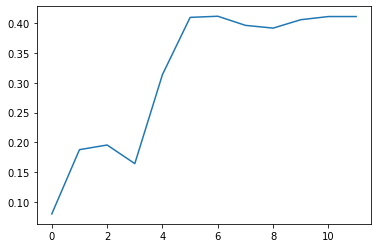

In [ ]:
epochs = np.arange(0,len(test_acc3),1)
plt.plot(epochs, test_acc3, label='Testing Accuracy')
plt.show()

## Training the final layer with ADAM

In [ ]:
PATH = './cifar_net.pth'
net = CIFAR10().to(device)
net.load_state_dict(torch.load(PATH))
nn.init.xavier_uniform_(net.fc3.weight)
PATH2 = './cifar_net2.pth'
torch.save(net.state_dict(), PATH2)

Testing Accuracy Score before training:  tensor(0.0766)
-- Generation 10 --
Current loss: 2.4336979389190674
Testing Accuracy Score:  tensor(0.3596)
-- Generation 20 --
Current loss: 0.6968751549720764
Testing Accuracy Score:  tensor(0.6686)
-- Generation 30 --
Current loss: 0.324710875749588
Testing Accuracy Score:  tensor(0.7314)
-- Generation 40 --
Current loss: 0.24266664683818817
Testing Accuracy Score:  tensor(0.7622)
-- Generation 50 --
Current loss: 0.20274122059345245
Testing Accuracy Score:  tensor(0.7704)
-- Generation 60 --
Current loss: 0.16860142350196838
Testing Accuracy Score:  tensor(0.7745)
-- Generation 70 --
Current loss: 0.12036635726690292
Testing Accuracy Score:  tensor(0.7790)
-- Generation 80 --
Current loss: 0.1395779699087143
Testing Accuracy Score:  tensor(0.7833)
-- Generation 90 --
Current loss: 0.1009480431675911
Testing Accuracy Score:  tensor(0.7869)
-- Generation 100 --
Current loss: 0.11115347594022751
Testing Accuracy Score:  tensor(0.7868)
Training 

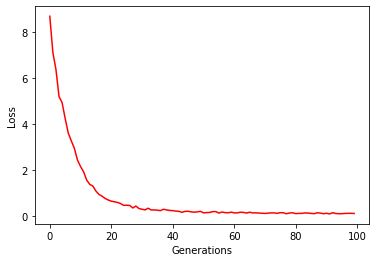

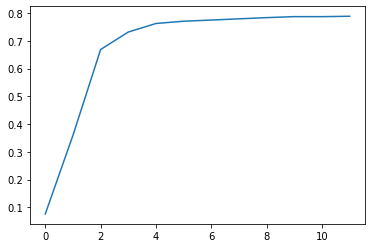

CPU times: user 50.7 s, sys: 773 ms, total: 51.5 s
Wall time: 51.4 s


In [ ]:
%%time

net = CIFAR10().to(device)
net.load_state_dict(torch.load(PATH2))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

net.conv1.requires_grad_(False)
net.conv2.requires_grad_(False)
net.conv3.requires_grad_(False)
net.conv4.requires_grad_(False)
net.conv5.requires_grad_(False)
net.conv6.requires_grad_(False)
net.fc1.requires_grad_(False)
net.fc2.requires_grad_(False)
net.fc3.requires_grad_(True)

train_acc = []
test_acc =[]
total_training_accuracies = []
total_testing_accuracies = []
for test_img, test_labels in test_loader:
        test_img = test_img.to(device)
        test_labels = test_labels.to(device)
        test_preds = net(test_img)
        metrics = accuracy_score(test_preds, test_labels)
        total_testing_accuracies.append(metrics)
print("Testing Accuracy Score before training: ", sum(total_testing_accuracies)/len(total_testing_accuracies))
test_acc.append(sum(total_testing_accuracies)/len(total_testing_accuracies))  
dspInterval = 10
losses = []
g = 0
for i in range(100):
    g = g + 1
    inputs, labels = next(iter(train_loader))
    inputs, labels = inputs.to(device), labels.to(device)
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if g%dspInterval ==0:
        print("-- Generation %i --" % g)
        print('Current loss:', loss.item())
        total_training_accuracies = []
        total_testing_accuracies = []
        for test_img, test_labels in test_loader:
            test_img = test_img.to(device)
            test_labels = test_labels.to(device)
            test_preds = net(test_img)
            metrics = accuracy_score(test_preds, test_labels)
            total_testing_accuracies.append(metrics)
        print("Testing Accuracy Score: ", sum(total_testing_accuracies)/len(total_testing_accuracies))
        test_acc.append(sum(total_testing_accuracies)/len(total_testing_accuracies))  
print('Training Complete')
total_training_accuracies = []
total_testing_accuracies = []
for test_img, test_labels in test_loader:
        test_img = test_img.to(device)
        test_labels = test_labels.to(device)
        test_preds = net(test_img)
        metrics = accuracy_score(test_preds, test_labels)
        total_testing_accuracies.append(metrics)
print("Testing Accuracy Score after training: ", sum(total_testing_accuracies)/len(total_testing_accuracies))    
test_acc.append(sum(total_testing_accuracies)/len(total_testing_accuracies))      
plt.plot(np.array(losses), 'r')
plt.ylabel('Loss')
plt.xlabel('Generations')
plt.show()
epochs = np.arange(0,len(test_acc),1)
plt.plot(epochs, test_acc, label='Testing Accuracy')
plt.show()

## Training the final layer with SGD: momentum and weight decay

Testing Accuracy Score before training:  tensor(0.0751)
-- Generation 10 --
Current loss: 0.33124107122421265
Testing Accuracy Score:  tensor(0.7398)
-- Generation 20 --
Current loss: 0.21501943469047546
Testing Accuracy Score:  tensor(0.7727)
-- Generation 30 --
Current loss: 0.12843437492847443
Testing Accuracy Score:  tensor(0.7764)
-- Generation 40 --
Current loss: 0.09513608366250992
Testing Accuracy Score:  tensor(0.7834)
-- Generation 50 --
Current loss: 0.12923593819141388
Testing Accuracy Score:  tensor(0.7836)
-- Generation 60 --
Current loss: 0.08116351068019867
Testing Accuracy Score:  tensor(0.7881)
-- Generation 70 --
Current loss: 0.10117250680923462
Testing Accuracy Score:  tensor(0.7921)
-- Generation 80 --
Current loss: 0.0871080681681633
Testing Accuracy Score:  tensor(0.7867)
-- Generation 90 --
Current loss: 0.09204494953155518
Testing Accuracy Score:  tensor(0.7912)
-- Generation 100 --
Current loss: 0.08634739369153976
Testing Accuracy Score:  tensor(0.7937)
Trai

Text(0.5, 0, 'Generations')

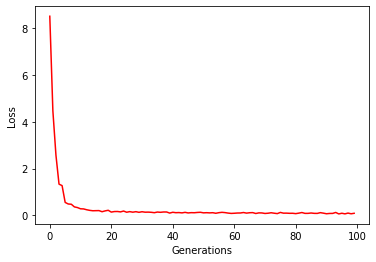

In [ ]:
%%time

net = CIFAR10().to(device)
net.load_state_dict(torch.load(PATH2))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.5, weight_decay = 0.01/100)

net.conv1.requires_grad_(False)
net.conv2.requires_grad_(False)
net.conv3.requires_grad_(False)
net.conv4.requires_grad_(False)
net.conv5.requires_grad_(False)
net.conv6.requires_grad_(False)
net.fc1.requires_grad_(False)
net.fc2.requires_grad_(False)
net.fc3.requires_grad_(True)

train_acc = []
test_acc2 =[]
total_training_accuracies = []
total_testing_accuracies = []
for test_img, test_labels in test_loader:
        test_img = test_img.to(device)
        test_labels = test_labels.to(device)
        test_preds = net(test_img)
        metrics = accuracy_score(test_preds, test_labels)
        total_testing_accuracies.append(metrics)
print("Testing Accuracy Score before training: ", sum(total_testing_accuracies)/len(total_testing_accuracies))
test_acc2.append(sum(total_testing_accuracies)/len(total_testing_accuracies))
dspInterval = 10
losses = []
g = 0
for i in range(100):
    g = g + 1
    inputs, labels = next(iter(train_loader))
    inputs, labels = inputs.to(device), labels.to(device)
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if g%dspInterval ==0:
        print("-- Generation %i --" % g)
        print('Current loss:', loss.item())
        total_training_accuracies = []
        total_testing_accuracies = []
        for test_img, test_labels in test_loader:
            test_img = test_img.to(device)
            test_labels = test_labels.to(device)
            test_preds = net(test_img)
            metrics = accuracy_score(test_preds, test_labels)
            total_testing_accuracies.append(metrics)
        print("Testing Accuracy Score: ", sum(total_testing_accuracies)/len(total_testing_accuracies))
        test_acc2.append(sum(total_testing_accuracies)/len(total_testing_accuracies))
print('Training Complete')
total_training_accuracies = []
total_testing_accuracies = []
for test_img, test_labels in test_loader:
        test_img = test_img.to(device)
        test_labels = test_labels.to(device)
        test_preds = net(test_img)
        metrics = accuracy_score(test_preds, test_labels)
        total_testing_accuracies.append(metrics)
print("Testing Accuracy Score after training: ", sum(total_testing_accuracies)/len(total_testing_accuracies))    
test_acc2.append(sum(total_testing_accuracies)/len(total_testing_accuracies))   
plt.plot(np.array(losses), 'r')
plt.ylabel('Loss')
plt.xlabel('Generations')

## Training the final layer with Adaptive SGD: Step Decay

Testing Accuracy Score before training:  tensor(0.0751)
-- Generation 10 --
Current loss: 0.28109994530677795
Testing Accuracy Score:  tensor(0.7464)
-- Generation 20 --
Current loss: 0.1804373562335968
Testing Accuracy Score:  tensor(0.7678)
-- Generation 30 --
Current loss: 0.17423215508460999
Testing Accuracy Score:  tensor(0.7727)
-- Generation 40 --
Current loss: 0.16159634292125702
Testing Accuracy Score:  tensor(0.7720)
-- Generation 50 --
Current loss: 0.0913340374827385
Testing Accuracy Score:  tensor(0.7799)
-- Generation 60 --
Current loss: 0.11677756905555725
Testing Accuracy Score:  tensor(0.7807)
-- Generation 70 --
Current loss: 0.10471475124359131
Testing Accuracy Score:  tensor(0.7837)
-- Generation 80 --
Current loss: 0.1343057006597519
Testing Accuracy Score:  tensor(0.7795)
-- Generation 90 --
Current loss: 0.12170383334159851
Testing Accuracy Score:  tensor(0.7855)
-- Generation 100 --
Current loss: 0.1015239804983139
Testing Accuracy Score:  tensor(0.7874)
Trainin

Text(0.5, 0, 'Generations')

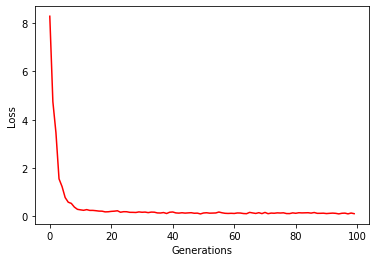

In [ ]:
%%time

net = CIFAR10().to(device)
net.load_state_dict(torch.load(PATH2))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.5, weight_decay = 0.01/100)
scheduler = StepLR(optimizer, step_size=10, gamma=0.8)

lrs = []

net.conv1.requires_grad_(False)
net.conv2.requires_grad_(False)
net.conv3.requires_grad_(False)
net.conv4.requires_grad_(False)
net.conv5.requires_grad_(False)
net.conv6.requires_grad_(False)
net.fc1.requires_grad_(False)
net.fc2.requires_grad_(False)
net.fc3.requires_grad_(True)

train_acc = []
test_acc4 =[]
total_training_accuracies = []
total_testing_accuracies = []
for test_img, test_labels in test_loader:
        test_img = test_img.to(device)
        test_labels = test_labels.to(device)
        test_preds = net(test_img)
        metrics = accuracy_score(test_preds, test_labels)
        total_testing_accuracies.append(metrics)
print("Testing Accuracy Score before training: ", sum(total_testing_accuracies)/len(total_testing_accuracies))
test_acc4.append(sum(total_testing_accuracies)/len(total_testing_accuracies))
dspInterval = 10
losses = []
g = 0
for i in range(100):
    g = g + 1
    inputs, labels = next(iter(train_loader))
    inputs, labels = inputs.to(device), labels.to(device)
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
    losses.append(loss.item())
    if g%dspInterval ==0:
        print("-- Generation %i --" % g)
        print('Current loss:', loss.item())
        total_training_accuracies = []
        total_testing_accuracies = []
        for test_img, test_labels in test_loader:
            test_img = test_img.to(device)
            test_labels = test_labels.to(device)
            test_preds = net(test_img)
            metrics = accuracy_score(test_preds, test_labels)
            total_testing_accuracies.append(metrics)
        print("Testing Accuracy Score: ", sum(total_testing_accuracies)/len(total_testing_accuracies))
        test_acc4.append(sum(total_testing_accuracies)/len(total_testing_accuracies))
print('Training Complete')
total_training_accuracies = []
total_testing_accuracies = []
for test_img, test_labels in test_loader:
        test_img = test_img.to(device)
        test_labels = test_labels.to(device)
        test_preds = net(test_img)
        metrics = accuracy_score(test_preds, test_labels)
        total_testing_accuracies.append(metrics)
print("Testing Accuracy Score after training: ", sum(total_testing_accuracies)/len(total_testing_accuracies))    
test_acc4.append(sum(total_testing_accuracies)/len(total_testing_accuracies))   
plt.plot(np.array(losses), 'r')
plt.ylabel('Loss')
plt.xlabel('Generations')

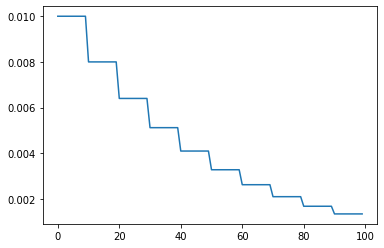

In [ ]:
plt.plot(range(100),lrs)

## Training the final layer with Adaptive SGD: Exponential Decay

Testing Accuracy Score before training:  tensor(0.0736)
-- Generation 10 --
Current loss: 0.30102092027664185
Testing Accuracy Score:  tensor(0.7455)
-- Generation 20 --
Current loss: 0.15788541734218597
Testing Accuracy Score:  tensor(0.7714)
-- Generation 30 --
Current loss: 0.13902701437473297
Testing Accuracy Score:  tensor(0.7755)
-- Generation 40 --
Current loss: 0.13855832815170288
Testing Accuracy Score:  tensor(0.7806)
-- Generation 50 --
Current loss: 0.13908855617046356
Testing Accuracy Score:  tensor(0.7857)
-- Generation 60 --
Current loss: 0.12089111655950546
Testing Accuracy Score:  tensor(0.7808)
-- Generation 70 --
Current loss: 0.1041371151804924
Testing Accuracy Score:  tensor(0.7835)
-- Generation 80 --
Current loss: 0.10495962202548981
Testing Accuracy Score:  tensor(0.7869)
-- Generation 90 --
Current loss: 0.10083479434251785
Testing Accuracy Score:  tensor(0.7889)
-- Generation 100 --
Current loss: 0.11571235209703445
Testing Accuracy Score:  tensor(0.7944)
Trai

Text(0.5, 0, 'Generations')

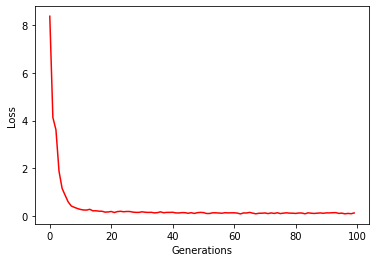

In [ ]:
%%time

net = CIFAR10().to(device)
net.load_state_dict(torch.load(PATH2))

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.5, weight_decay = 0.01/100)
scheduler = ExponentialLR(optimizer, gamma=0.99)

lrs = []

net.conv1.requires_grad_(False)
net.conv2.requires_grad_(False)
net.conv3.requires_grad_(False)
net.conv4.requires_grad_(False)
net.conv5.requires_grad_(False)
net.conv6.requires_grad_(False)
net.fc1.requires_grad_(False)
net.fc2.requires_grad_(False)
net.fc3.requires_grad_(True)

train_acc = []
test_acc5 =[]
total_training_accuracies = []
total_testing_accuracies = []
for test_img, test_labels in test_loader:
        test_img = test_img.to(device)
        test_labels = test_labels.to(device)
        test_preds = net(test_img)
        metrics = accuracy_score(test_preds, test_labels)
        total_testing_accuracies.append(metrics)
print("Testing Accuracy Score before training: ", sum(total_testing_accuracies)/len(total_testing_accuracies))
test_acc5.append(sum(total_testing_accuracies)/len(total_testing_accuracies))
dspInterval = 10
losses = []
g = 0
for i in range(100):
    g = g + 1
    inputs, labels = next(iter(train_loader))
    inputs, labels = inputs.to(device), labels.to(device)
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
    losses.append(loss.item())
    if g%dspInterval ==0:
        print("-- Generation %i --" % g)
        print('Current loss:', loss.item())
        total_training_accuracies = []
        total_testing_accuracies = []
        for test_img, test_labels in test_loader:
            test_img = test_img.to(device)
            test_labels = test_labels.to(device)
            test_preds = net(test_img)
            metrics = accuracy_score(test_preds, test_labels)
            total_testing_accuracies.append(metrics)
        print("Testing Accuracy Score: ", sum(total_testing_accuracies)/len(total_testing_accuracies))
        test_acc5.append(sum(total_testing_accuracies)/len(total_testing_accuracies))
print('Training Complete')
total_training_accuracies = []
total_testing_accuracies = []
for test_img, test_labels in test_loader:
        test_img = test_img.to(device)
        test_labels = test_labels.to(device)
        test_preds = net(test_img)
        metrics = accuracy_score(test_preds, test_labels)
        total_testing_accuracies.append(metrics)
print("Testing Accuracy Score after training: ", sum(total_testing_accuracies)/len(total_testing_accuracies))    
test_acc5.append(sum(total_testing_accuracies)/len(total_testing_accuracies))   
plt.plot(np.array(losses), 'r')
plt.ylabel('Loss')
plt.xlabel('Generations')

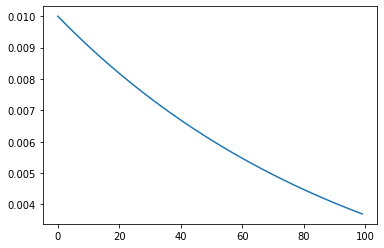

In [ ]:
plt.plot(range(100),lrs)

## Comparing Optimizers

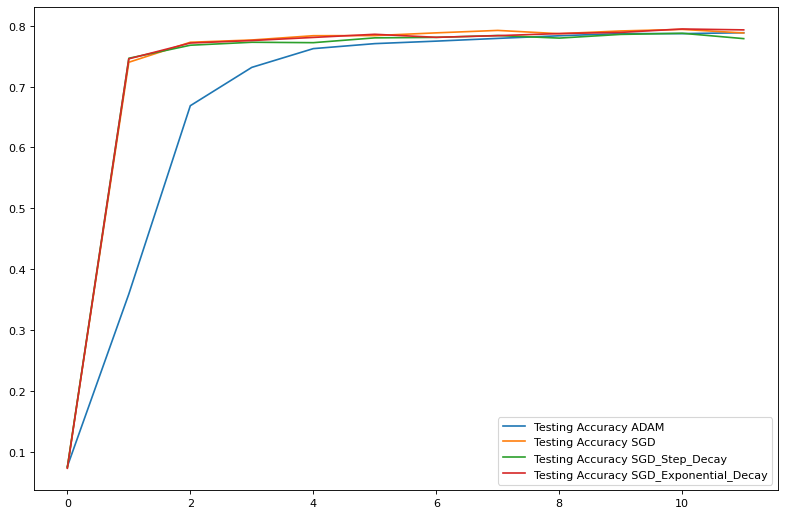

In [ ]:
epochs = np.arange(0,len(test_acc4),1)
plt.figure(figsize=(12, 8), dpi=80)
plt.plot(epochs, test_acc, label='Testing Accuracy ADAM')
plt.plot(epochs, test_acc2, label='Testing Accuracy SGD')
# plt.plot(epochs, test_acc3, label='Testing Accuracy GA')
plt.plot(epochs, test_acc4, label='Testing Accuracy SGD_Step_Decay')
plt.plot(epochs, test_acc5, label='Testing Accuracy SGD_Exponential_Decay')
plt.legend()

## Bi-objective with NSGAII

imports done


/user/HS401/jp01702/.local/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/user/HS401/jp01702/.local/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


ready to begin
  Evaluated 100 individuals
-- Generation 10 --
  Worst loss 29.10996437072754
  Best loss 10.944040298461914
  Avg loss 14.814475409217337
  Std loss 0.013385329563405806
  Best Gaussian Reg 0.0005525900533925299
  Worst Gaussian Reg 0.0005715983444301467
-- Generation 20 --
  Worst loss 26.583019256591797
  Best loss 7.004835605621338
  Avg loss 10.843792939610214
  Std loss 0.026704511763032825
  Best Gaussian Reg 0.0005429359473436965
  Worst Gaussian Reg 0.0005594252397344068
-- Generation 30 --
  Worst loss 23.016685485839844
  Best loss 6.17553186416626
  Avg loss 8.949492528478078
  Std loss 0.034760969751757666
  Best Gaussian Reg 0.000538808306250959
  Worst Gaussian Reg 0.0005513612673555631
-- Generation 40 --
  Worst loss 13.470794677734375
  Best loss 6.216364860534668
  Avg loss 7.729602444378622
  Std loss 0.026831781914362432
  Best Gaussian Reg 0.0005334646503804093
  Worst Gaussian Reg 0.0005461480429206227
-- Generation 50 --
  Worst loss 13.308415412

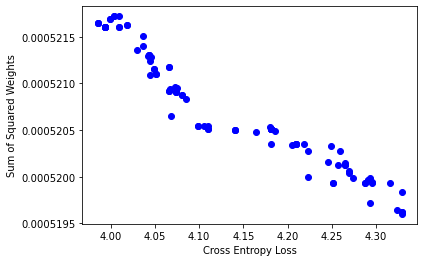

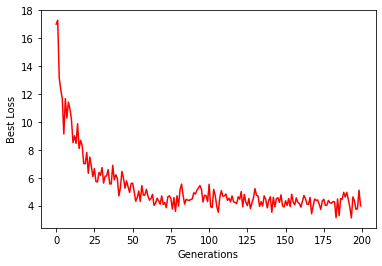

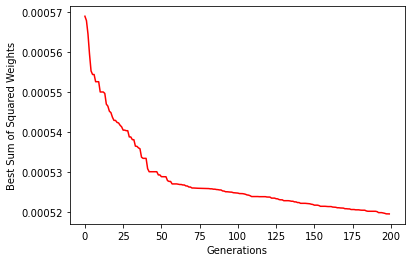

CPU times: user 36min 14s, sys: 2.03 s, total: 36min 16s
Wall time: 36min 8s


In [ ]:
%%time

from deap import creator, base, tools, algorithms
from deap import benchmarks
from deap.benchmarks.tools import diversity, convergence, hypervolume
import random
from sympy.combinatorics.graycode import GrayCode
from sympy.combinatorics.graycode import gray_to_bin
from sympy.combinatorics.graycode import bin_to_gray
import numpy as np

import array
import random
import json
import matplotlib.pyplot as plt

print('imports done')

loss_func = nn.CrossEntropyLoss()

net = CIFAR10().to(device)
net.load_state_dict(torch.load(PATH))

creator.create("FitnessMax", base.Fitness, weights=(1.0, 1.0))
creator.create("Individual", list, fitness=creator.FitnessMax)

popSize     = 100 #Population size
dimension   = 5130 #Number of decision variable x 
numOfBits   = 10 #Number of bits in the decision variable
iterations  = 200 #Number of generations to be run
dspInterval = 10 #display interval for stats
nElitists   = 1 #number of elite individuals selected
#omega       = 5
crossProb   = 0.6 #crossover probability
flipProb    = 1. / (dimension * numOfBits) #bit mutate prob
mutateprob  = .15 #mutation prob
maxnum      = 2**numOfBits #absolute max size of number coded by binary list 1,0,0,1,1,....

list_fits = []
list_gaus = []

toolbox = base.Toolbox()

# Attribute generator 
#                      define 'attr_bool' to be an attribute ('gene')
#                      which corresponds to integers sampled uniformly
#                      from the range [0,1] (i.e. 0 or 1 with equal
#                      probability)
toolbox.register("attr_bool", random.randint, 0, 1)

# Structure initializers
#                         define 'individual' to be an individual
#                         consisting of numOfBits*dimension 'attr_bool' elements ('genes')
toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_bool, numOfBits*dimension)

# define the population to be a list of individuals
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    
#----------
# Operator registration
#----------

# register the crossover operator
toolbox.register("mate", tools.cxTwoPoint)

# register a mutation operator with a probability to
# flip each attribute/gene of 0.05
toolbox.register("mutate", tools.mutFlipBit, indpb=flipProb)

#use NSGAII to select from the population
toolbox.register("select", tools.selNSGA2)

#----------

# Convert chromosome to real number
# input: list binary 1,0 of length numOfBits representing number using gray coding
# output: real value
def chrom2real(c):
    indasstring=''.join(map(str, c))
    degray=gray_to_bin(indasstring)
    numasint=int(degray, 2) # convert to int from base 2 list
    num = (numasint/512) - 1 
    return num

#convert the population from binary genes into real valued weights
def weightify(pop):
    weights = []
    for n in range(len(pop)):
        for  i in range(dimension):
            i = pop[n][10*i:10*(i+1)]
            weights.append(chrom2real(i))
    weights = np.array(weights, dtype = 'float32')
    weights = np.reshape(weights, (len(pop), dimension))
    return(weights)

#insert the weights into the neural network
def weightsIntoNetwork(weights):
    net.fc3.weight = torch.nn.Parameter(torch.from_numpy(weights[0:5120].reshape(10,512), ))
    net.fc3.bias = torch.nn.Parameter(torch.from_numpy(weights[5120:5130]))
    net.fc3.to(device)
print('ready to begin')

def main():

    # create an initial population of individuals (where each individual is a list of integers)
    pop = toolbox.population(n=(popSize))

# Evaluate the entire population on one batch of images

    inputs, labels = next(iter(train_loader))
    inputs, labels = inputs.to(device), labels.to(device)
    fitnesses = []
    weights = weightify(pop)
    for i in range(len(pop)):
        weightsIntoNetwork(weights[i,])
        out = net(inputs)
        fitnesses.append(tuple([1/(loss_func(out, labels).item()),(sum(sum(net.fc3.weight**2))).item()]))
        
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    pop = toolbox.select(pop, len(pop))
    print("  Evaluated %i individuals" % len(pop))
    
    # Variable keeping track of the number of generations
    g = 0
    
    # Begin the evolution
    while g < iterations:
        # A new generation
        g = g + 1
        
        #load a new batch of images
        inputs, labels = next(iter(train_loader))
        inputs, labels = inputs.to(device), labels.to(device)
        #evaluate whole population on the new batch of images
        fitnesses = []
        weights = weightify(pop)
        for i in range(len(pop)):
            weightsIntoNetwork(weights[i,])
            out = net(inputs)
            fitnesses.append(tuple([1/(loss_func(out, labels).item()),(sum(sum(net.fc3.weight**2))).item()]))       
    # Evaluate the entire population
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit
        # Select the next generation individuals
        offspring = tools.selTournamentDCD(pop, len(pop))
        # selTournamentDCD means Tournament selection based on dominance (D) 
        # followed by crowding distance (CD). This selection requires the 
        # individuals to have a crowding_dist attribute
        offspring = [toolbox.clone(ind) for ind in offspring]
    
        # Apply crossover and mutation on the offspring
        # make pairs of offspring for crossing over
        for child1, child2 in zip(offspring[::2], offspring[1::2]):

            # cross two individuals with probability CXPB
            if random.random() < crossProb:
                #print('before crossover ',child1, child2)
                toolbox.mate(child1, child2)
                #print('after crossover ',child1, child2)

                # fitness values of the children must be recalculated later
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:

            # mutate an individual with probability mutateprob
            if random.random() < mutateprob:
                toolbox.mutate(mutant)
                del mutant.fitness.values
        
        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]

        fitnesses = []
        weights = weightify(invalid_ind)
        for i in range(len(invalid_ind)):
            weightsIntoNetwork(weights[i,])
            out = net(inputs)
            fitnesses.append(tuple([1/(loss_func(out, labels).item()),(sum(sum(net.fc3.weight**2))).item()]))
        
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        
        # Select the next generation population
        pop = toolbox.select(pop + offspring, popSize)       
        
        fits = [ind.fitness.values[0] for ind in pop]
        list_fits.append(1/max(fits))
        gaus = [ind.fitness.values[1] for ind in pop]
        list_gaus.append(1/max(gaus))
        if g%dspInterval ==0:
            # Gather print fitness stats
            length = len(pop)
            mean = sum(fits) / length
            sum2 = sum(x*x for x in fits)
            std = abs(sum2 / length - mean**2)**0.5
            mean_gaus = sum(gaus) / len(gaus)
            print("-- Generation %i --" % g)
            print("  Worst loss %s" % (1/min(fits)))
            print("  Best loss %s" % (1/max(fits)))
            print("  Avg loss %s" % (1/mean))
            print("  Std loss %s" % std)
            print("  Best Gaussian Reg %s" % (1/max(gaus)))
            print("  Worst Gaussian Reg %s" % (1/min(gaus)))
            print("  Worst Gaussian Reg %s" % (1/(mean_gaus)))

    print("-- End of (successful) evolution --")
        
    
    return(pop)
#     best_ind = tools.selBest(pop, 1)[0]

#     best_weights = []
#     for  i in range(dimension):
#         i = best_ind[10*i:10*(i+1)]
#         best_weights.append(chrom2real(i))
#     weightsFinal = np.array(best_weights, dtype = 'float32')

#     inputs, labels = next(iter(train_loader))
#     weightsIntoNetwork(weightsFinal)
#     out = net(inputs)
#     loss = loss_func(out, labels).item()
#     print('Best MSE is:')
#     print(loss)
#     correct = 0
#     total = 0
#     with torch.no_grad():
#             for data in test_loader:
#                 images, labels = data
#         # calculate outputs by running images through the network
#                 outputs = net(images)
#         # the class with the highest energy is what we choose as prediction
#                 _, predicted = torch.max(outputs.data, 1)
#                 total += labels.size(0)
#                 correct += (predicted == labels).sum().item()
#     print(f'Accuracy of the individual with the best loss value on the 10000 test images: {100 * correct // total} %')

if __name__ == "__main__":
    pop = main()
    pop.sort(key=lambda x: x.fitness.values)
    front = np.array([ind.fitness.values for ind in pop])
    flip_front = 1/front
    plt.scatter(flip_front[:,0], flip_front[:,1], c="b")
    plt.axis("tight")
    plt.ylabel('Sum of Squared Weights')
    plt.xlabel('Cross Entropy Loss')
    plt.show()

#torch.tensor.detach().   

plt.plot(np.array(list_fits), 'r')
plt.ylabel('Best Loss')
plt.xlabel('Generations')
plt.show()
plt.plot(np.array(list_gaus), 'r')
plt.ylabel('Best Sum of Squared Weights')
plt.xlabel('Generations')
plt.show()

Evaluating Child  1
Evaluating Child  2
Evaluating Child  3
Evaluating Child  4
Evaluating Child  5
Evaluating Child  6
Evaluating Child  7
Evaluating Child  8
Evaluating Child  9
Evaluating Child  10
Evaluating Child  11
Evaluating Child  12
Evaluating Child  13
Evaluating Child  14
Evaluating Child  15
Evaluating Child  16
Evaluating Child  17
Evaluating Child  18
Evaluating Child  19
Evaluating Child  20
Evaluating Child  21
Evaluating Child  22
Evaluating Child  23
Evaluating Child  24
Evaluating Child  25
Evaluating Child  26
Evaluating Child  27
Evaluating Child  28
Evaluating Child  29
Evaluating Child  30
Evaluating Child  31
Evaluating Child  32
Evaluating Child  33
Evaluating Child  34
Evaluating Child  35
Evaluating Child  36
Evaluating Child  37
Evaluating Child  38
Evaluating Child  39
Evaluating Child  40
Evaluating Child  41
Evaluating Child  42
Evaluating Child  43
Evaluating Child  44
Evaluating Child  45
Evaluating Child  46
Evaluating Child  47
Evaluating Child  48
E

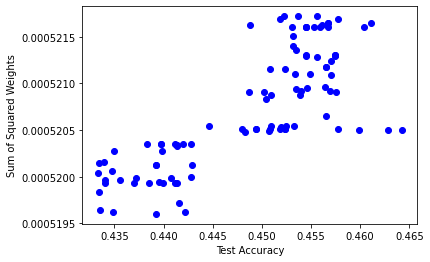

CPU times: user 6min 2s, sys: 87.8 ms, total: 6min 2s
Wall time: 6min 1s


In [ ]:
%%time
pop_acc = []
pop.sort(key=lambda x: x.fitness.values)
weights = weightify(pop)
for i in range(len(pop)):
    print('Evaluating Child ', i+1)
    weightsIntoNetwork(weights[i,])
    total_training_accuracies = []
    total_testing_accuracies = []
    for test_img, test_labels in test_loader:
        test_img = test_img.to(device)
        test_labels = test_labels.to(device)
        test_preds = net(test_img)
        metrics = accuracy_score(test_preds, test_labels)
        total_testing_accuracies.append(metrics)
    pop_acc.append(sum(total_testing_accuracies)/len(total_testing_accuracies))
front = np.array([ind.fitness.values for ind in pop])
flip_front = 1/front

# print(flip_front)
# print(flip_front[:,1])
# print(pop_acc)
plt.scatter(pop_acc, flip_front[:,1], c="b")
plt.axis("tight")
plt.ylabel('Sum of Squared Weights')
plt.xlabel('Test Accuracy')
plt.show()

In [ ]:
print('Best accuracy: ',max(pop_acc).item())

Best accuracy:  0.4642578065395355
